# Extended solution
The notebook contains several examples of how you can use the extended solution.

In [7]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import textwrap
import math

In [8]:
class ComplexRadar():
    """
    Create a complex radar chart with different scales for each variable

    Parameters
    ----------
    fig : figure object
        A matplotlib figure object to add the axes on
    variables : list
        A list of variables
    ranges : list
        A list of tuples (min, max) for each variable
    n_ring_levels: int, defaults to 5
        Number of ordinate or ring levels to draw
    show_scales: bool, defaults to True
        Indicates if we the ranges for each variable are plotted
    format_cfg: dict, defaults to None
        A dictionary with formatting configurations

    """
    def __init__(self, fig, variables, ranges, n_ring_levels=5, show_scales=True, format_cfg=None):
        
        # Default formatting
        self.format_cfg = {
            # Axes
            # https://matplotlib.org/stable/api/figure_api.html
            'axes_args': {},
            # Tick labels on the scales
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.rgrids.html
            'rgrid_tick_lbls_args': {'fontsize':8},
            # Radial (circle) lines
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.grid.html
            'rad_ln_args': {},
            # Angle lines
            # https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D
            'angle_ln_args': {},
            # Include last value (endpoint) on scale
            'incl_endpoint':False,
            # Variable labels (ThetaTickLabel)
            'theta_tick_lbls':{'va':'top', 'ha':'center'},
            'theta_tick_lbls_txt_wrap':15,
            'theta_tick_lbls_brk_lng_wrds':False,
            'theta_tick_lbls_pad':25,
            # Outer ring
            # https://matplotlib.org/stable/api/spines_api.html
            'outer_ring':{'visible':True, 'color':'#d6d6d6'}
        }
        
        if format_cfg is not None:
            self.format_cfg = { k:(format_cfg[k]) if k in format_cfg.keys() else (self.format_cfg[k]) 
                 for k in self.format_cfg.keys()}        
        
        
        # Calculate angles and create for each variable an axes
        # Consider here the trick with having the first axes element twice (len+1)
        angles = np.arange(0, 360, 360./len(variables))
        axes = [fig.add_axes([0.1,0.1,0.9,0.9], 
                             polar=True,
                             label = "axes{}".format(i),
                             **self.format_cfg['axes_args']) for i in range(len(variables)+1)]
        
        # Ensure clockwise rotation (first variable at the top N)
        for ax in axes:
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            ax.set_axisbelow(True)
        
        # Writing the ranges on each axes
        for i, ax in enumerate(axes):

            # Here we do the trick by repeating the first iteration
            j = 0 if (i==0 or i==1) else i-1
            ax.set_ylim(*ranges[j])
            # Set endpoint to True if you like to have values right before the last circle
            grid = np.linspace(*ranges[j], num=n_ring_levels, 
                               endpoint=self.format_cfg['incl_endpoint'])
            gridlabel = ["{}".format(round(x,2)) for x in grid]
            gridlabel[0] = "" # remove values from the center
            lines, labels = ax.set_rgrids(grid, 
                              labels=gridlabel, 
                              angle=angles[j],
                              **self.format_cfg['rgrid_tick_lbls_args']
                              )
            
            ax.set_ylim(*ranges[j])
            ax.spines["polar"].set_visible(False)
            ax.grid(visible=False)
            
            if show_scales == False:
                ax.set_yticklabels([])

        # Set all axes except the first one unvisible
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            
        # Setting the attributes
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        self.ax1 = axes[1]
        self.plot_counter = 0
        
        
        # Draw (inner) circles and lines
        self.ax.yaxis.grid(**self.format_cfg['rad_ln_args'])
        # Draw outer circle
        self.ax.spines['polar'].set(**self.format_cfg['outer_ring'])
        # Draw angle lines
        self.ax.xaxis.grid(**self.format_cfg['angle_ln_args'])

        # ax1 is the duplicate of axes[0] (self.ax)
        # Remove everything from ax1 except the plot itself
        self.ax1.axis('off')
        self.ax1.set_zorder(9)
        
        # Create the outer labels for each variable
        l, text = self.ax.set_thetagrids(angles, labels=variables)
        
        # Beautify them
        labels = [t.get_text() for t in self.ax.get_xticklabels()]
        labels = ['\n'.join(textwrap.wrap(l, self.format_cfg['theta_tick_lbls_txt_wrap'], 
                            break_long_words=self.format_cfg['theta_tick_lbls_brk_lng_wrds'])) for l in labels]
        self.ax.set_xticklabels(labels, **self.format_cfg['theta_tick_lbls'])
        
        for t,a in zip(self.ax.get_xticklabels(),angles):
            # if a == 0:
            #     t.set_ha('center')
            # elif a > 0 and a < 180:
            #     t.set_ha('left')
            # elif a == 180:
            #     t.set_ha('center')
            # else:
            #     t.set_ha('right')
            t.set_ha('center')

        self.ax.tick_params(axis='both', pad=self.format_cfg['theta_tick_lbls_pad'])


    def _scale_data(self, data, ranges):
        """Scales data[1:] to ranges[0]"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)
        return sdata
        
    def plot(self, data, *args, **kwargs):
        """Plots a line"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        self.plot_counter = self.plot_counter+1
    
    def fill(self, data, *args, **kwargs):
        """Plots an area"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        
    def use_legend(self, *args, **kwargs):
        """Shows a legend"""
        self.ax1.legend(*args, **kwargs)
    
    def set_title(self, title, pad=25, **kwargs):
        """Set a title"""
        self.ax.set_title(title,pad=pad, **kwargs)
    
    def set_text(self, *args, **kwargs):
        self.ax.set_text(*args, **kwargs)

# Examples
The following section shows several examples of how to use the solution above

In [9]:
import pandas as pd
from io import StringIO

html_string = """
<table>
<thead>
  <tr>
    <th align="left">Model</th>
    <th>Size</th>
    <th>MME</th>
    <th nowrap="nowrap">MMB dev (en)</th>
    <th nowrap="nowrap" >MMMU val</th>
    <th nowrap="nowrap" >MMHal-Bench</th>
    <th nowrap="nowrap" >Object HalBench</th>
    <th nowrap="nowrap" >SeedBench-I</th>
    <th>MathVista</th>
    <th nowrap="nowrap" >LLaVA Bench W</th>
  </tr>
</thead>
<tbody align="center">
  <tr>
    <td align="left">GPT-4V†</td>
    <td>-</td>
    <td>1409</td>
    <td>75.1 </td>
    <td>56.8</td>
    <td>3.53 / 70.8</td>
    <td>86.4 / 92.7</td>
    <td>71.6 </td>
    <td>47.8 </td>
    <td>93.1 </td>
  </tr>
  <tr>
    <td nowrap="nowrap" align="left">Qwen-VL-Plus†</td>
    <td>-</td>
    <td>1681</td>
    <td>66.2 </td>
    <td>45.2</td>
    <td>- </td>
    <td>- </td>
    <td>65.7 </td>
    <td>36.0 </td>
    <td>73.7 </td>
  </tr>
  <tr>
    <td align="left">Yi-VL 6B</td>
    <td align="right">6.7B </td>
    <td>- </td>
    <td>68.2 </td>
    <td>39.1 </td>
    <td>- </td>
    <td>- </td>
    <td>66.1 </td>
    <td>28.0 </td>
    <td>39.9 </td>
  </tr>
  <tr>
    <td nowrap="nowrap" align="left" >Qwen-VL-Chat</td>
    <td align="right">9.6B</td>
    <td>1488</td>
    <td>60.6 </td>
    <td>35.9</td>
    <td>2.93 / 59.4</td>
    <td>56.2 / 80.0</td>
    <td>64.8 </td>
    <td>33.8 </td>
    <td>67.7 </td>
  </tr>
  <tr>
    <td align="left" >CogVLM</td>
    <td align="right">17.4B</td>
    <td>1438</td>
    <td>63.7 </td>
    <td>32.1 </td>
    <td>2.68 / 52.1 </td>
    <td>73.6 / 87.4 </td>
    <td>68.8 </td>
    <td>34.7 </td>
    <td>73.9 </td>
  </tr>
  <tr>
    <td align="left" >LLaVA 1.5</td>
    <td align="right">13.6B </td>
    <td>1531 </td>
    <td>68.2 </td>
    <td>36.4 </td>
    <td>2.71 / 51.0 </td>
    <td>53.7 / 77.4 </td>
    <td>68.1 </td>
    <td>26.4 </td>
    <td>64.6 </td>
  </tr>
  <tr>
    <td nowrap="nowrap" align="left" ><b>OmniLMM-12B</b></td>
    <td align="right">11.6B </td>
    <td>1637 </td>
    <td>71.6 </td>
    <td>40.7 </td>
    <td>3.45 / 68.8 </td>
    <td>90.3 / 95.5 </td>
    <td>71.1 </td>
    <td>34.9 </td>
    <td>72.0 </td>
  </tr>
</tbody>
</table>
"""

df = pd.read_html(StringIO(html_string))[0]

print(df)

           Model   Size   MME  MMB dev (en)  MMMU val  MMHal-Bench  \
0        GPT-4V†      -  1409          75.1      56.8  3.53 / 70.8   
1  Qwen-VL-Plus†      -  1681          66.2      45.2            -   
2       Yi-VL 6B   6.7B     -          68.2      39.1            -   
3   Qwen-VL-Chat   9.6B  1488          60.6      35.9  2.93 / 59.4   
4         CogVLM  17.4B  1438          63.7      32.1  2.68 / 52.1   
5      LLaVA 1.5  13.6B  1531          68.2      36.4  2.71 / 51.0   
6    OmniLMM-12B  11.6B  1637          71.6      40.7  3.45 / 68.8   

  Object HalBench  SeedBench-I  MathVista  LLaVA Bench W  
0     86.4 / 92.7         71.6       47.8           93.1  
1               -         65.7       36.0           73.7  
2               -         66.1       28.0           39.9  
3     56.2 / 80.0         64.8       33.8           67.7  
4     73.6 / 87.4         68.8       34.7           73.9  
5     53.7 / 77.4         68.1       26.4           64.6  
6     90.3 / 95.5         

In [10]:
# TR I2T
# IR T2I

methods = ["$GPT-4V^†$", "$Qwen-VL-Plus^†$", 'Yi-VL 6B', 'Qwen-VL-Chat', 'CogVLM', 'LLaVA 1.5', 'OmniLMM-12B']
data = {
  "MME": [1409, 1681, 'N/A', 1488, 1438, 1531, 1637],
  "MMB dev (en)": [75.1, 66.2, 68.2, 60.6, 63.7, 68.2, 71.6],
  "MMMU val": [56.8, 45.2, 39.1, 35.9, 32.1, 36.4, 40.7],
  "MMHal-Bench": [70.8, 'N/A', 'N/A', 59.4, 52.1, 51.0, 68.8],
  "Object HalBench": [92.7, 'N/A', 'N/A', 80.0, 87.4, 77.4, 95.5],
  "SeedBench-I": [71.6, 65.7, 66.1, 64.8, 68.8, 68.1, 71.1],
  "MathVista": [47.8, 36.0, 28.0, 33.8, 34.7, 26.4, 34.9],
  "LLaVA Bench W": [93.1, 73.7, 39.9, 67.7, 73.9, 64.6, 72.0],

}
data_min_max = {
  "MME": [1200, 1789],
  "MMB dev (en)": [50, 78.9],
  "MMMU val": [9, 51],
  "MMHal-Bench": [40, 78],
  "Object HalBench": [60, 107],
  "SeedBench-I": [63, 73.8],
  "MathVista": [15, 41.6],
  "LLaVA Bench W": [38, 85.6],
}

new_data = {}
for k, v in data.items():
  v_min = data_min_max[k][0]
  new_v = []
  for vv in v:
    if vv == 'N/A':
      new_v.append(v_min)
    else:
      new_v.append(vv)
  new_data[k] = new_v

print(new_data)
data = new_data


{'MME': [1409, 1681, 1200, 1488, 1438, 1531, 1637], 'MMB dev (en)': [75.1, 66.2, 68.2, 60.6, 63.7, 68.2, 71.6], 'MMMU val': [56.8, 45.2, 39.1, 35.9, 32.1, 36.4, 40.7], 'MMHal-Bench': [70.8, 40, 40, 59.4, 52.1, 51.0, 68.8], 'Object HalBench': [92.7, 60, 60, 80.0, 87.4, 77.4, 95.5], 'SeedBench-I': [71.6, 65.7, 66.1, 64.8, 68.8, 68.1, 71.1], 'MathVista': [47.8, 36.0, 28.0, 33.8, 34.7, 26.4, 34.9], 'LLaVA Bench W': [93.1, 73.7, 39.9, 67.7, 73.9, 64.6, 72.0]}


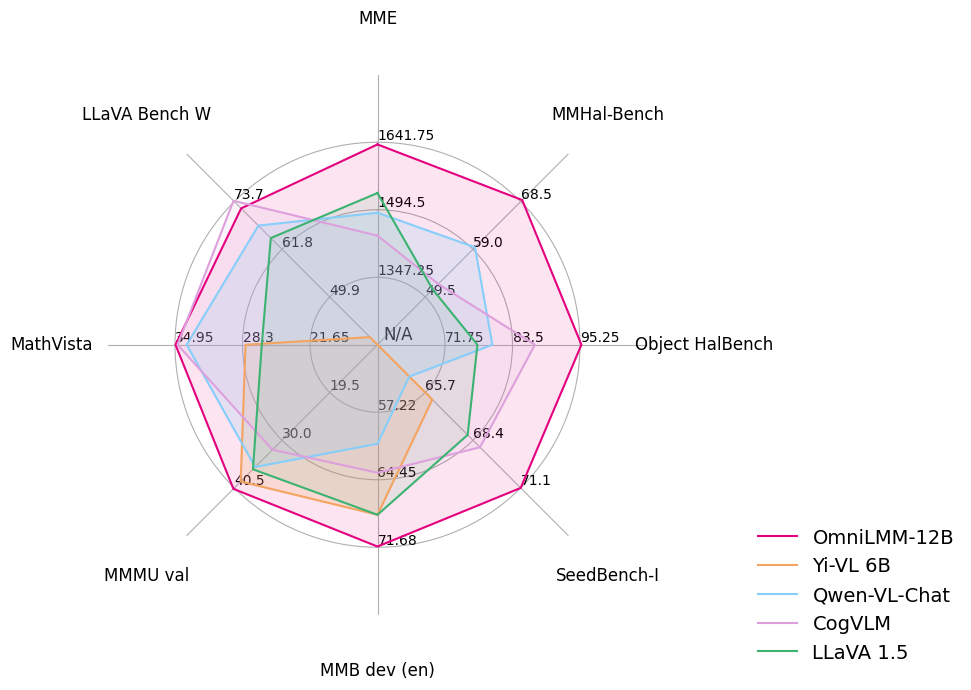

In [16]:

variables = [
    "MME", 
      "MMHal-Bench", 
        "Object HalBench", 
      "SeedBench-I", 



  "MMB dev (en)", 
  "MMMU val", 


  "MathVista", 
  "LLaVA Bench W",

  ]
# shuffle variables
# import random
# random.shuffle(variables)
ranges = [data_min_max[i] for i in variables]
format_cfg = {
    'rad_ln_args': {'visible':True},
    'angle_ln_args':{'visible':True},
    'rgrid_tick_lbls_args': {'fontsize':10},
    'theta_tick_lbls_pad': 30,
    'outer_ring':{'visible':False, 'color':'#d6d6d6'},
    'theta_tick_lbls':{'va':'center', 'ha':'center', 'fontsize':12},
}


fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges, n_ring_levels=4, show_scales=True, format_cfg=format_cfg)

# custom_colors = ['#DDA0DD', '#F5C6D1', '#FAF7B6', '#C2F2FF', '#3CB371']
custom_colors = ['#F5C6D1', '#FFD700', '#F4A460', '#87CEFA', '#DDA0DD', '#3CB371', '#E4007F']
custom_alphas = [0.35, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1]

# for g in [4, 1, 2, 3, 0, 5, 6]:
for g in [6, 2, 3, 4, 5]:
  radar.plot([i[g] for i in [data[j] for j in variables]], label=f"{methods[g]}", color=custom_colors[g])
  radar.fill([i[g] for i in [data[j] for j in variables]], alpha=custom_alphas[g], color=custom_colors[g])

# radar.set_title("Radar chart solution with different scales", pad=25)
radar.use_legend(**{'loc':'lower right', 'bbox_to_anchor':(1.6, -0.12), 'ncol':radar.plot_counter, 'fontsize':14, 'ncol':1, 'frameon':False})

plt.text(0.56, 0.56, 'N/A', transform=plt.gcf().transFigure, fontsize=12)

# plt.show() 
plt.savefig('./radar_compare.pdf', dpi=500, bbox_inches='tight')